In [2]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from torchvision.models.detection import (
#    fasterrcnn_resnet50_fpn, 
#    FasterRCNN_ResNet50_FPN_Weights
#    )
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
from torchvision.transforms import functional as F
import numpy as np

In [2]:
def load_model(checkpoint_path, num_classes=4):
#def load_model(checkpoint_path, num_classes=3):
    # 1. Инициализация модели с предобученными весами backbone
    #weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    #model = fasterrcnn_resnet50_fpn(weights=weights)
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    
    # 2. Замена box_predictor для своего числа классов
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # 3. Загрузка checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # 4. Извлекаем только веса модели (игнорируем optimizer и epoch)
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # 5. Аккуратная загрузка весов
    model.load_state_dict(state_dict, strict=False)  # strict=False пропустит отсутствующие ключи
    
    # 6. Перевод в режим оценки
    model.eval()
    
    return model

In [3]:
model = load_model(
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning/exp/summary/27-03-2025-20-48-49/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning/exp/summary/02-04-2025-21-19-48/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning-v2/exp/summary/04-04-2025-23-09-41/best_model.pth',
    checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning-v2/exp/summary/09-04-2025-06-15-03/best_model.pth',
    num_classes=4  # Укажите реальное число ваших классов (3 класса + фон)
    #num_classes=3  # Укажите реальное число ваших классов (версия 2: 3 класса без фона)
    )

In [4]:
def detect_objects(model, image_path, confidence_threshold=0.7):
    """
    Детекция объектов на изображении с помощью загруженной модели
    Args:
        model: Загруженная модель Faster R-CNN
        image_path: Путь к изображению
        confidence_threshold: Порог уверенности для отображения (0.0-1.0)
    Returns:
        Словарь с результатами детекции
    """
    # 1. Загрузка и преобразование изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV -> RGB
    image_tensor = F.to_tensor(image)  # Конвертация в тензор [0-1]

    # 2. Добавление batch dimension и перемещение на устройство (GPU/CPU)
    image_tensor = image_tensor.unsqueeze(0).to(next(model.parameters()).device)
    
    # 3. Запуск модели (без вычисления градиентов)
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # 4. Фильтрация результатов по порогу уверенности
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_classes = predictions[0]['labels'].cpu().numpy()
    
    keep = pred_scores >= confidence_threshold
    results = {
        'boxes': pred_boxes[keep],
        'scores': pred_scores[keep],
        'classes': pred_classes[keep]
    }
    
    return results

In [5]:
def visualize_results_matplotlib(image_path, results, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    
    for box, score, cls in zip(results['boxes'], results['scores'], results['classes']):
        x1, y1, x2, y2 = map(int, box)
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor=colors[cls % len(colors)], facecolor='none'
        )
        ax.add_patch(rect)
        
        plt.text(
            x1, y1-10, f"{class_names[cls]}: {score:.2f}",
            color=colors[cls % len(colors)], fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    plt.axis('off')
    plt.show()

In [6]:
#image_path = '/home/lastinm/PROJECTS/CV/Card Detection.v3i.coco(added 8 images, resized split)/test/images/1742460932138_resized_jpg.rf.0ee03bf49164c59d1ff4b929d05132cf.jpg'
#image_path = '/home/lastinm/PROJECTS/CV/Card Detection.v3i.coco(added 8 images, resized split)/test/images/1742460932082_resized_jpg.rf.aef35db4511433e34957f93e3272468f.jpg'
image_path = '/home/lastinm/PROJECTS/FINAL/test_img/card26_jpg.rf.9defe96ac5b853d3f84650575dc86d39.jpg'

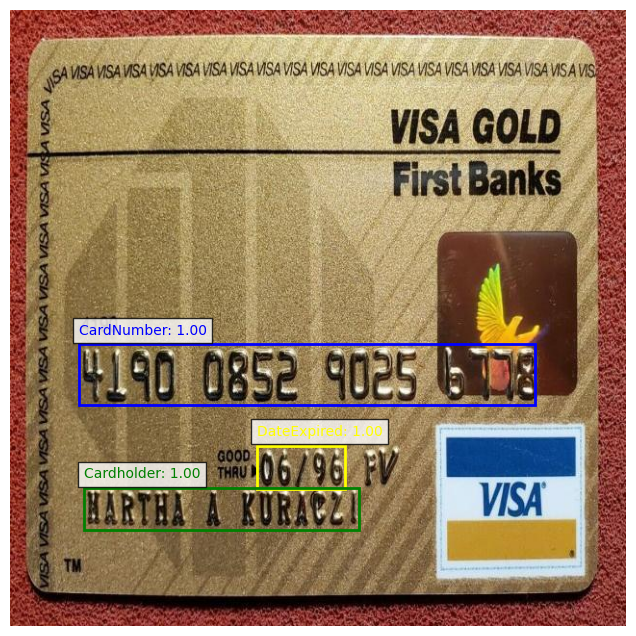

Найдено объектов: 3
Объект 1: CardNumber (уверенность: 1.00)
Координаты: x1=71.3, y1=347.8, x2=545.4, y2=410.2
Объект 2: DateExpired (уверенность: 1.00)
Координаты: x1=256.9, y1=452.7, x2=349.0, y2=497.9
Объект 3: Cardholder (уверенность: 1.00)
Координаты: x1=76.8, y1=496.7, x2=362.8, y2=540.9


In [7]:
# 1. Детекция на изображении
results = detect_objects(
    model=model,
    image_path=image_path,
    confidence_threshold=0.5  # Можно регулировать
    )
    
# 2. Визуализация
class_names = ["Background", "Cardholder", "CardNumber", "DateExpired"]  # Пример
visualize_results_matplotlib(image_path, results, class_names)
    
# 3. Вывод результатов в консоль
print(f"Найдено объектов: {len(results['boxes'])}")
for i, (box, score, cls) in enumerate(zip(results['boxes'], results['scores'], results['classes'])):
    print(f"Объект {i+1}: {class_names[cls]} (уверенность: {score:.2f})")
    print(f"Координаты: x1={box[0]:.1f}, y1={box[1]:.1f}, x2={box[2]:.1f}, y2={box[3]:.1f}")

In [ ]:
import os
import shutil

In [9]:
def prepare_output_dir(output_dir):
    """Более простая версия с полным удалением папки"""
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

In [10]:
def save_and_display_bboxes(image_path, results, output_dir='output', confidence_threshold=0.5):
    """
    Сохраняет и отображает изображения с bounding boxes
    
    Args:
        image_path: путь к исходному изображению
        results: результаты детекции (словарь с 'boxes', 'scores', 'classes')
        output_dir: директория для сохранения результатов
        confidence_threshold: порог уверенности для отображения
    """
    # Создаем директорию для результатов
    prepare_output_dir(output_dir)
    
    # Загружаем изображение
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image_with_boxes = image.copy()
    
    # Получаем данные из результатов
    boxes = results['boxes']
    scores = results['scores']
    classes = results['classes']

    # Получаем базовое имя файла без расширения
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    ext = os.path.splitext(image_path)[1]
       
    # Сохраняем каждую обнаруженную область отдельно
    for i, (box, score, cls) in enumerate(zip(boxes, scores, classes)):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = map(int, box)
            cropped = image[y1:y2, x1:x2]
            
            if cropped.size > 0:  # Проверяем, что область не пустая
                # Формируем имя файла с классом в начале
                crop_path = os.path.join(output_dir, f'{cls}_{base_name}_crop{i}{ext}')
                Image.fromarray(cropped).save(crop_path)
                
                # Выводим обрезанные области
                plt.figure(figsize=(6, 4))
                plt.imshow(cropped)
                plt.title(f"Class {cls}, Score: {score:.2f}")
                plt.axis('off')
                plt.show()

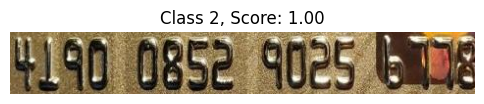

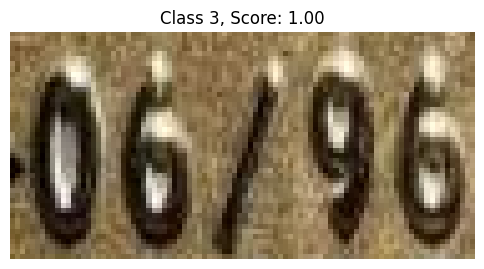

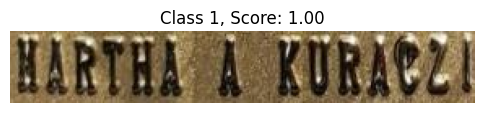

In [11]:
# Сохраняем и отображаем результаты
save_and_display_bboxes(image_path, results, confidence_threshold=0.7)

# Распознавание Keras OCR

In [3]:
import keras_ocr
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models

2025-04-20 23:05:51.319342: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 23:05:51.345224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-20 23:05:51.345251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 23:05:51.345936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 23:05:51.350531: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# DateExpired
#img_path = '/home/lastinm/PROJECTS/credit_cards_detection/artefacts/3_0.91_AgACAgIAAxkBAAICb2gDc1odBGUeYrwLDCqbVKbzKukKAALx7jEb9jsYSCYoYdOUlI6-AQADAgADeAADNgQ.jpeg'
# 4190 0852 9025 6778
image_path = '/home/lastinm/PROJECTS/credit_cards_detection/artefacts/2_0.93_AgACAgIAAxkBAAICb2gDc1odBGUeYrwLDCqbVKbzKukKAALx7jEb9jsYSCYoYdOUlI6-AQADAgADeAADNgQ.jpeg'
#image_path = '/home/lastinm/PROJECTS/credit_cards_detection/artefacts/AgACAgIAAxkBAAICb2gDc1odBGUeYrwLDCqbVKbzKukKAALx7jEb9jsYSCYoYdOUlI6-AQADAgADeAADNgQ.jpeg'
    # Загружаем изображение
image = keras_ocr.tools.read(image_path)
height, width = image.shape[:2]

In [13]:
# Для создания набора символов
import string
alphabet = string.ascii_letters + '!?. '
recognizer_digits = string.digits + '/ '
recognizer_alphabet = ''.join(sorted(set(alphabet.upper())))

In [4]:
def visualize_enhanced_results(orig_path, results, class_id, processed_img):
    """Визуализация с сравнением оригинального и обработанного изображения"""
    orig_img = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Оригинальное изображение
    ax1.imshow(orig_img)
    ax1.set_title(f"Оригинал (Класс {class_id})")
    
    # Обработанное изображение
    ax2.imshow(processed_img, cmap='gray')
    ax2.set_title("После обработки")
    
    # Рисуем bounding boxes на оригинале
    for (bbox, text, prob) in results:
        (tl, tr, br, bl) = bbox
        tl = (int(tl[0]), int(tl[1]))
        br = (int(br[0]), int(br[1]))
        
        rect = patches.Rectangle(tl, br[0]-tl[0], br[1]-tl[1],
                               linewidth=2, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(tl[0], tl[1]-10, f"{text} ({prob:.2f})",
                color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Вывод результатов
    print("Распознанный текст:")
    for i, (_, text, prob) in enumerate(results):
        print(f"{i+1}. {text} (точность: {prob:.2f})")

In [ ]:
def keras_to_easyocr_format(keras_results):
    easyocr_format = []
    for text, box in keras_results[0]:
        # Преобразование координат углов в плоский список
        flattened_box = np.array(box).flatten().tolist()
        
        # Оценка уверенности (keras-ocr не возвращает confidence, можно использовать фиксированное значение)
        confidence = 0.9  # Замените на реальное значение, если доступно
        
        easyocr_format.append((flattened_box, text, confidence))
    
    return easyocr_format

In [ ]:
def recognize_images_in_directory(directory, languages=['en', 'ru'], gpu=False):
    """
    Распознает текст на изображениях с учетом класса из имени файла
    
    Args:
        directory: путь к директории с изображениями
        languages: список языков для распознавания
        gpu: использовать ли GPU
    """
    # recognizer = keras_ocr.recognition.Recognizer(alphabet=recognizer_alphabet,
    #                                           weights='kurapan')
    # detector = keras_ocr.detection.Detector(weights='clovaai_general')   
    
    # Получаем список файлов
    image_files = [f for f in os.listdir(directory) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    if not image_files:
        print(f"В директории {directory} не найдено изображений")
        return
    
    print(f"Найдено {len(image_files)} изображений для распознавания...")
    
    # Обрабатываем каждое изображение
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        print(f"\nОбработка файла: {img_file}")
        
        try:
            # Извлекаем класс из имени файла (первый символ перед '_')
            class_id = img_file.split('_')[0]
            
            # Настройки распознавания в зависимости от класса
            # allowlist = None
            # if class_id == '2':  # Только цифры
            #     # recognizer = keras_ocr.recognition.Recognizer(alphabet=recognizer_digits, weights='kurapan')
            #     print("Режим распознавания: только цифры")
            # elif class_id == '3':  # Цифры и символ '/'
            #     # recognizer = keras_ocr.recognition.Recognizer(alphabet=recognizer_digits, weights='kurapan')
            #     print("Режим распознавания: цифры и символ /")
            
            # Загрузка и предобработка изображения
            img = cv2.imread(img_path)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Увеличьте маленький текст:
            img = cv2.resize(img, None, fx=2, fy=1, interpolation=cv2.INTER_CUBIC)

            # # Улучшение контраста (CLAHE)
            #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
            #img = clahe.apply(img)
            
            # # Бинаризация (адаптивный метод)
            #img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            #                           cv2.THRESH_BINARY_INV, 11, 2)
            
            # Увеличение резкости (для мелкого текста)
            #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            #img = cv2.filter2D(img, -1, kernel)
            
            # Распознавание с улучшенными параметрами
            pipeline = keras_ocr.pipeline.Pipeline(
                # recognizer=recognizer,
                # detector=detector,
                #scale=2,
                #max_size=width/2
            )

            results_keras = pipeline.recognize([img])

            #results = keras_to_easyocr_format(results_keras)
            
            # Визуализация с указанием класса
            #visualize_enhanced_results(img_path, results, class_id, img)
                            
        except Exception as e:
            print(f"Ошибка при обработке файла {img_file}: {str(e)}")

In [16]:
output_dir = 'output'  # директория с изображениями
recognize_images_in_directory(output_dir, languages=['en'], gpu=False)

Найдено 3 изображений для распознавания...

Обработка файла: 2_card26_jpg.rf.9defe96ac5b853d3f84650575dc86d39_crop0.jpg
Looking for /home/lastinm/.keras-ocr/craft_mlt_25k.h5
Looking for /home/lastinm/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 1s/step
Ошибка при обработке файла 2_card26_jpg.rf.9defe96ac5b853d3f84650575dc86d39_crop0.jpg: too many values to unpack (expected 2)

Обработка файла: 3_card26_jpg.rf.9defe96ac5b853d3f84650575dc86d39_crop1.jpg
Looking for /home/lastinm/.keras-ocr/craft_mlt_25k.h5
Looking for /home/lastinm/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 1s/step
Ошибка при обработке файла 3_card26_jpg.rf.9defe96ac5b853d3f84650575dc86d39_crop1.jpg: not enough values to unpack (expected 2, got 1)

Обработка файла: 1_card26_jpg.rf.9defe96ac5b853d3f84650575dc86d39_crop2.jpg
Looking for /home/lastinm/.keras-ocr/craft_mlt_25k.h5
Looking for /home/lastinm/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 1s